# pySCENIC protocol: PBMC10k

September 2019

Dataset: *10k PBMCs from a Healthy Donor* available from 10x Genomics ([here](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_v3)).

**Note: This shortened version is based on the instructions laid out in the original paper:
https://www.nature.com/articles/s41596-020-0336-2**

Also see this for scanpy tutorials: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

## 1. Import files and dependencies

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import pickle as pk
#from MulticoreTSNE import MulticoreTSNE as TSNE
from IPython.core.debugger import set_trace

In [2]:
# set variables for file paths to read from and write to:

# set a working directory
wdir = "/home/jovyan/work/dask_k8s/PBMC_project/work_dir"
os.chdir( wdir )

# path to unfiltered loom file (this will be created in the optional steps below)
f_loom_path_unfilt = "intermediate/pbmc10k_unfiltered.loom" # test dataset, n=500 cells

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "intermediate/pbmc10k_filtered_scenic.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "intermediate/anndata.h5ad"

# path to pyscenic output
f_pyscenic_output = "intermediate/pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'intermediate/pbmc10k_scenic_integrated-output.loom'

#Path to float32 csv expression matrix
ex_matrix_path = 'intermediate/pbmc10k_filtered_scenic.csv'

#Path to final int64 pickle expression matrix
ex_matrix_path_final = 'intermediate/pbmc10k_filtered_scenic_final.pkl'

#Motif annotations
MOTIF_ANNOTATIONS_FNAME = 'input/motifs-v9-nr.hgnc-m0.001-o0.0.tbl'

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                 9.4.0
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
cloudpickle         2.2.0
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.0
dask                2023.1.0
dateutil            2.8.2
debugpy             1.6.5
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           1.2.0
h5py                3.8.0
hypergeom_ufunc     NA
importlib_resources NA
invgauss_ufunc      NA
ipykernel           6.20.1
ipython_genutils    0.2.0
jedi                0.18.2
jinja2              3.1.2
joblib              1.2.0
jupyter_server      2.1.0
kiwisolver          1.4.4
llvmlite            0.39.1
loompy              3.0.7
lz4                 4.2.0
markupsafe          2.1.1
matplotlib          3.7.1
mpl_toolkits        NA
natsort             8.3.1
nbinom_

In [4]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 20

#### Connecting to Dask scheduler

In [5]:
from dask.distributed import Client, progress
c = Client()
c

<Client: 'tcp://10.42.5.64:8786' processes=1 threads=6, memory=9.31 GiB>

## 2. Expression data import
There are several ways to import expression data. For simplicity we focus on getting the data into a Scanpy anndata object or a loom file.  Scanpy provides functions for reading in a wide variety of formats (described [here](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/index.html#reading)).

### Reading in expression data: 10x Genomics mtx files
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.

In [6]:
f_mtx_dir = '/home/jovyan/work/dask_k8s/PBMC_project/work_dir/input/filtered_feature_bc_matrix/'

adata = sc.read_10x_mtx(
    f_mtx_dir ,                 # the directory with the `.mtx` file
    var_names='gene_symbols',   # use gene symbols for the variable names (variables-axis index)
    cache=True) 



... reading from cache file cache/home-jovyan-work-dask_k8s-PBMC_project-work_dir-input-filtered_feature_bc_matrix-matrix.h5ad


In [7]:
#Checking data
adata

AnnData object with n_obs × n_vars = 11769 × 33538
    var: 'gene_ids', 'feature_types'

In [8]:
#Note: This command is only present in the publication
adata.var_names_make_unique()

### Saving to an un-filtered loom file

In [9]:
row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}

lp.create( f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs )

## 3. Further pre-processing of expression data

### a. Cleaning and quality control

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# read unfiltered data from a loom file
adata = sc.read_loom( f_loom_path_unfilt )

In [12]:
#Determining counts per gene and cells per gene 
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  3567008.0
Number of cells in which each gene is detected: 0  -  11766


In [13]:
#Getting the pyscenic thresholds (what thresholds???)
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  353.07
minSamples:  117.69


#### ***Article's steps start here***

In [14]:
# compute the number of genes per cell (computes ‘n_genes' column) 
sc.pp.filter_cells(adata, min_genes=0)

In [15]:
# mito and genes/counts cuts 
mito_genes = adata.var_names.str.startswith('MT-')

In [16]:
# for each cell compute fraction of counts in mito genes vs. all genes 
adata.obs['percent_mito'] = np.ravel(np.sum( adata[:, mito_genes].X, axis=1)) / np.ravel(np.sum(adata.X, axis=1))

In [17]:
# add the total counts per cell as observations-annotation to adata 
adata.obs['n_counts'] = np.ravel(adata.X.sum(axis=1))

### b. Diagnostic plots, pre-filtering

#### Number of genes expressed per cell

/tmp/ipykernel_359/1413385581.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
/tmp/ipykernel_359/1413385581.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
/tmp/ipykernel_359/1413385581.py:10: UserWarning: 

`d

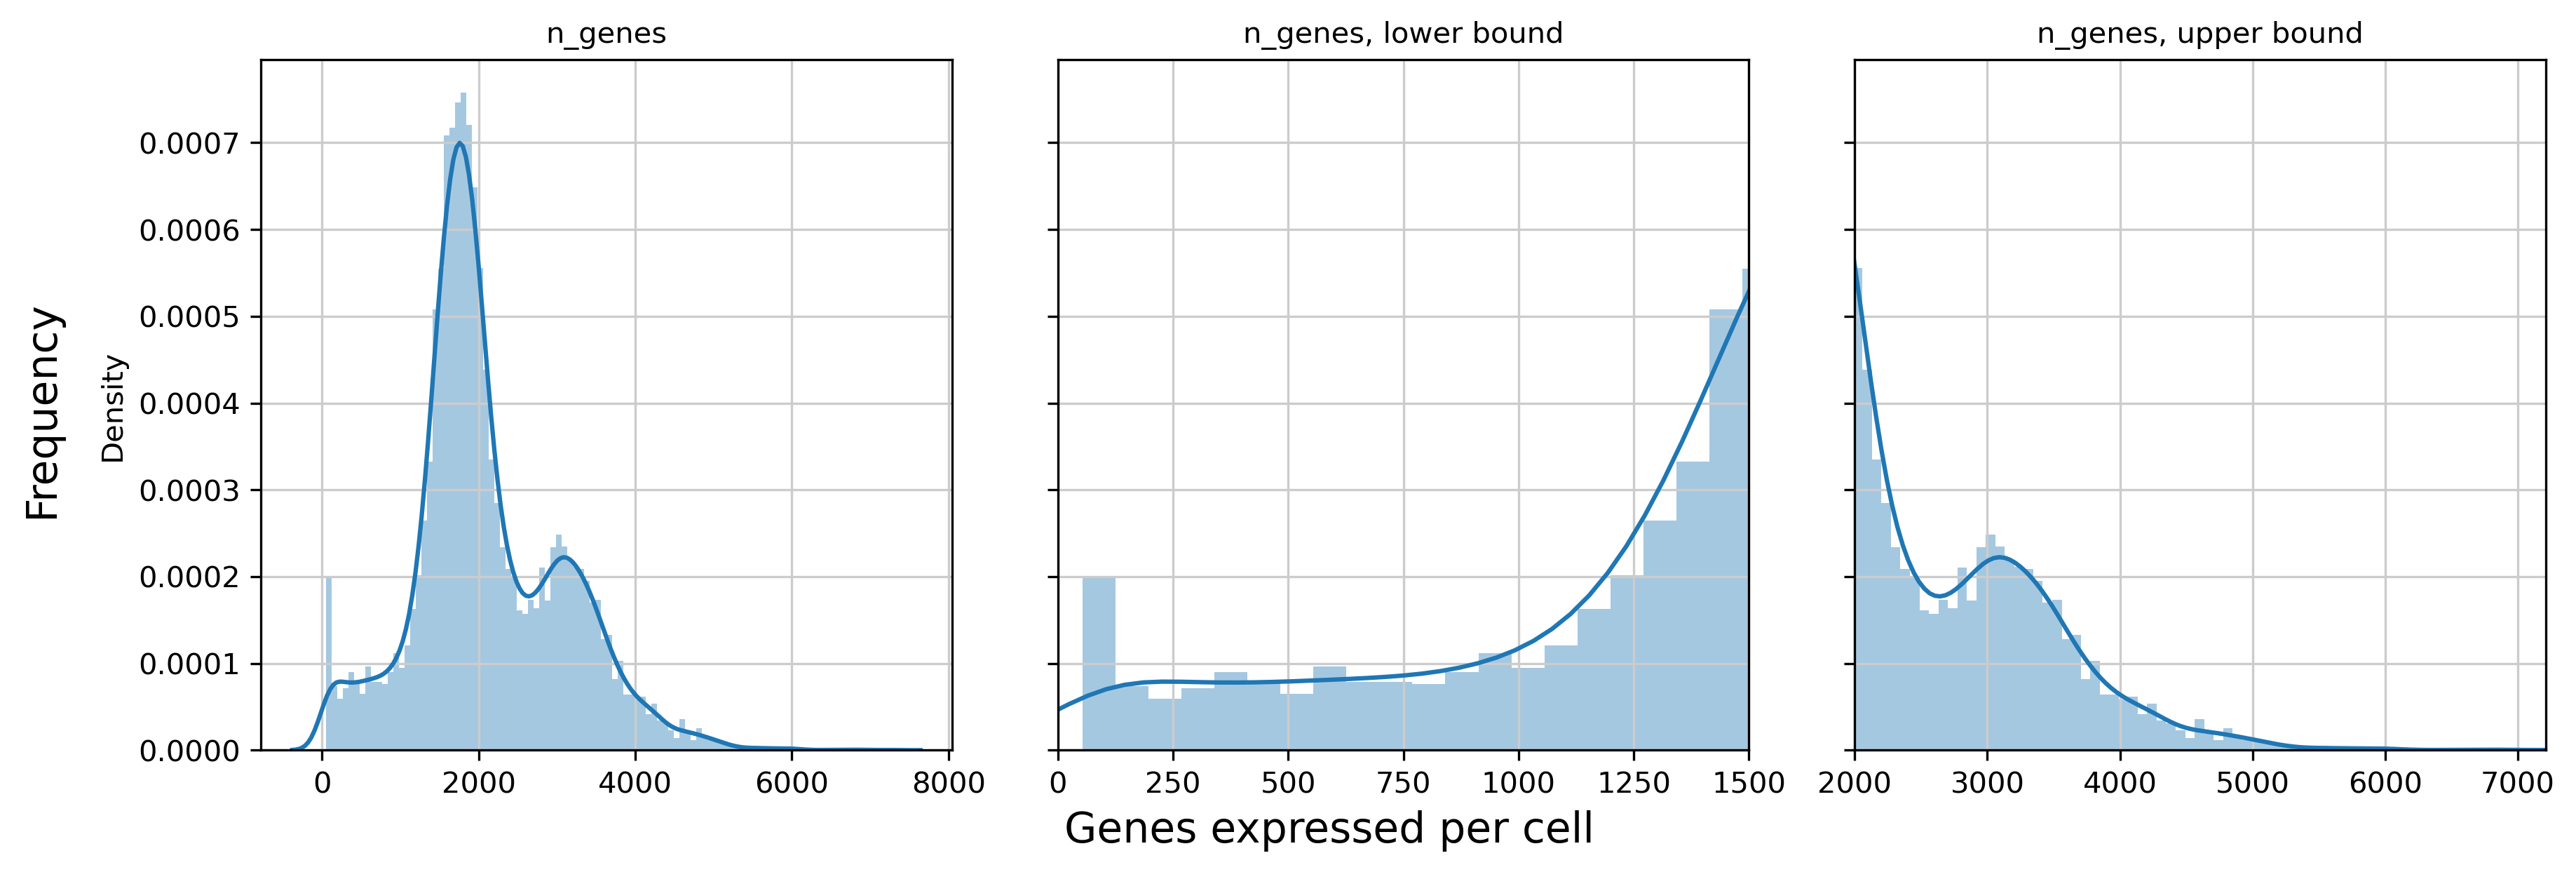

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

#### Percentage of mitochondrial reads per cell

/tmp/ipykernel_359/1055941436.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
/tmp/ipykernel_359/1055941436.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
/tmp/ipykernel

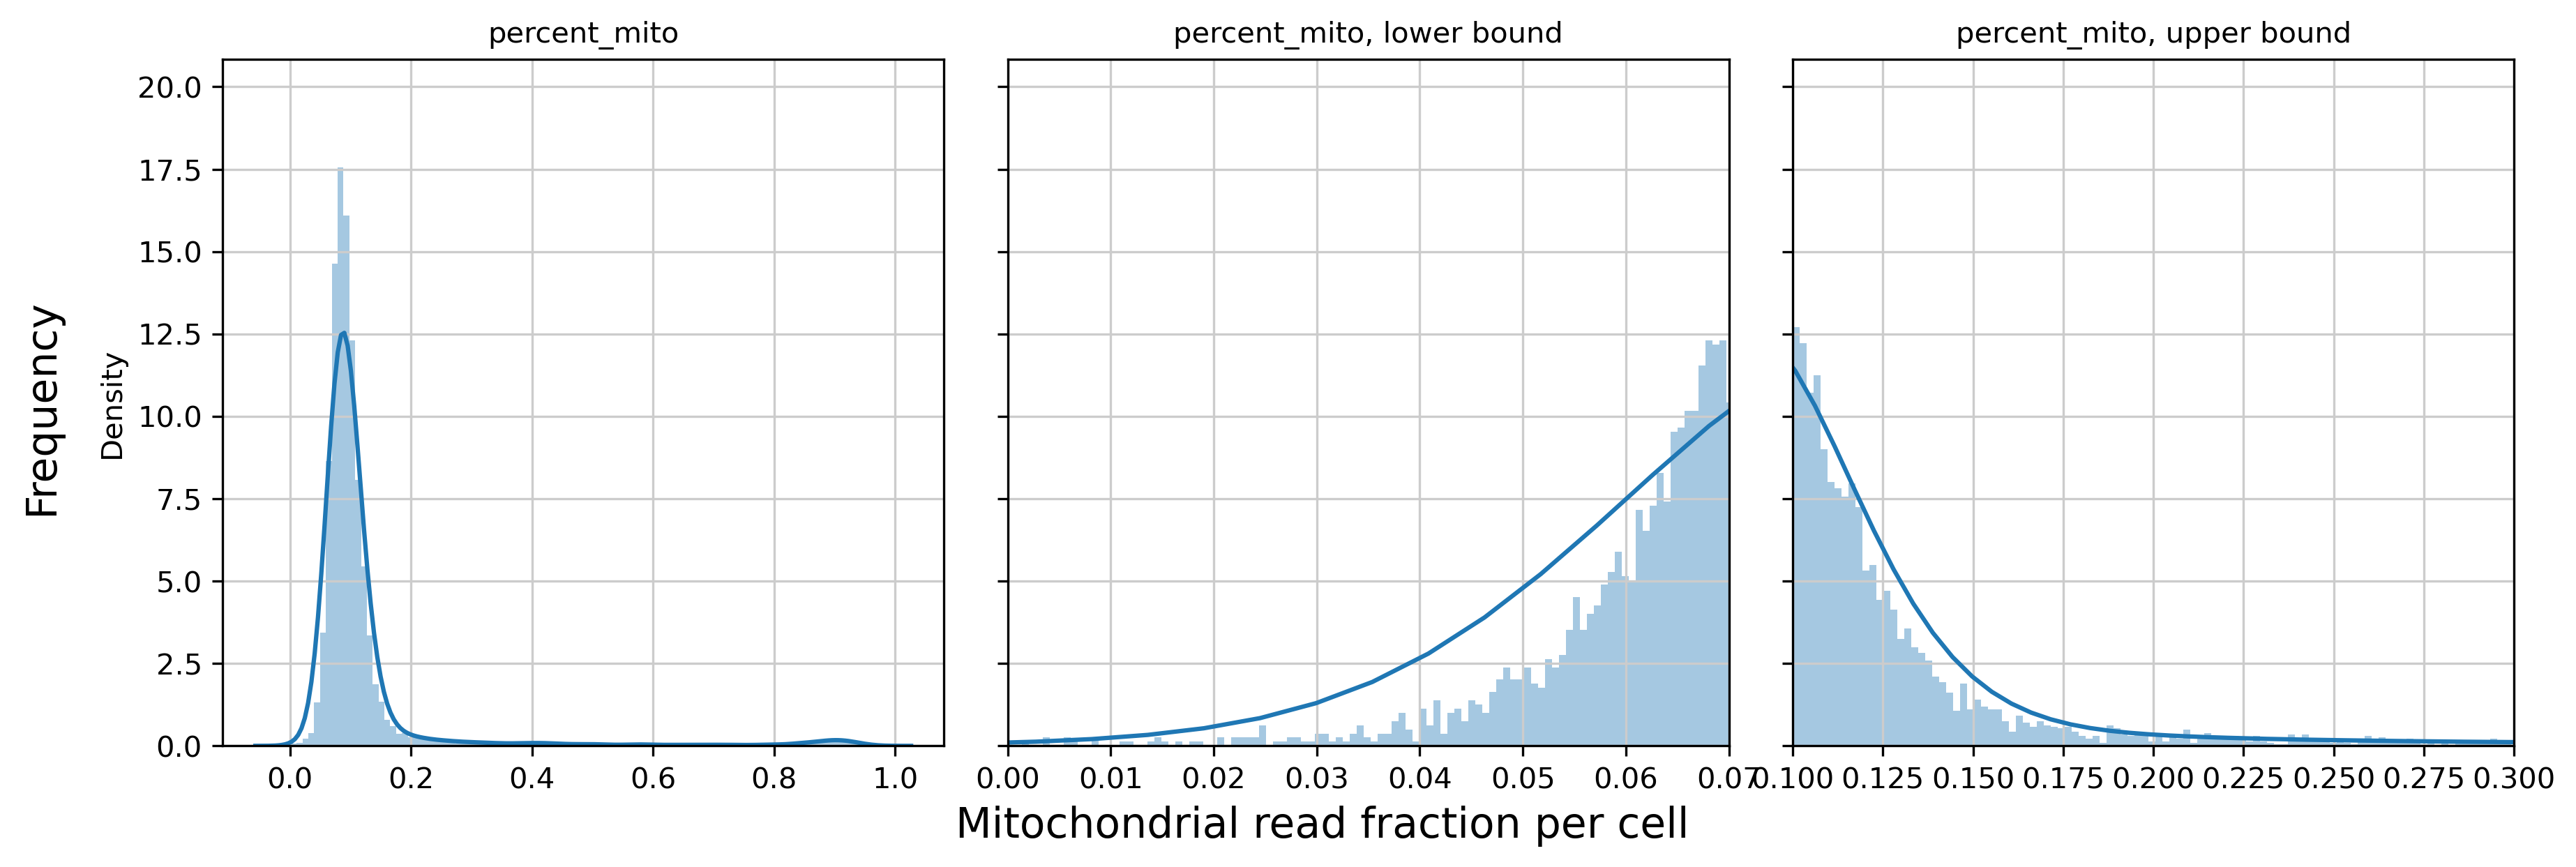

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['percent_mito']
x_lowerbound = [0.0, 0.07 ]
x_upperbound = [ 0.10, 0.3 ]
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
sns.distplot(x, ax=ax3, norm_hist=True, bins=int(nbins/(x_upperbound[1]-x_upperbound[0])) )

ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1] )
for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('percent_mito')
ax2.title.set_text('percent_mito, lower bound')
ax3.title.set_text('percent_mito, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial read fraction per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

#### Three-panel summary plots

/tmp/ipykernel_359/3363066550.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
/tmp/ipykernel_359/3363066550.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
/tmp/ipykernel_35

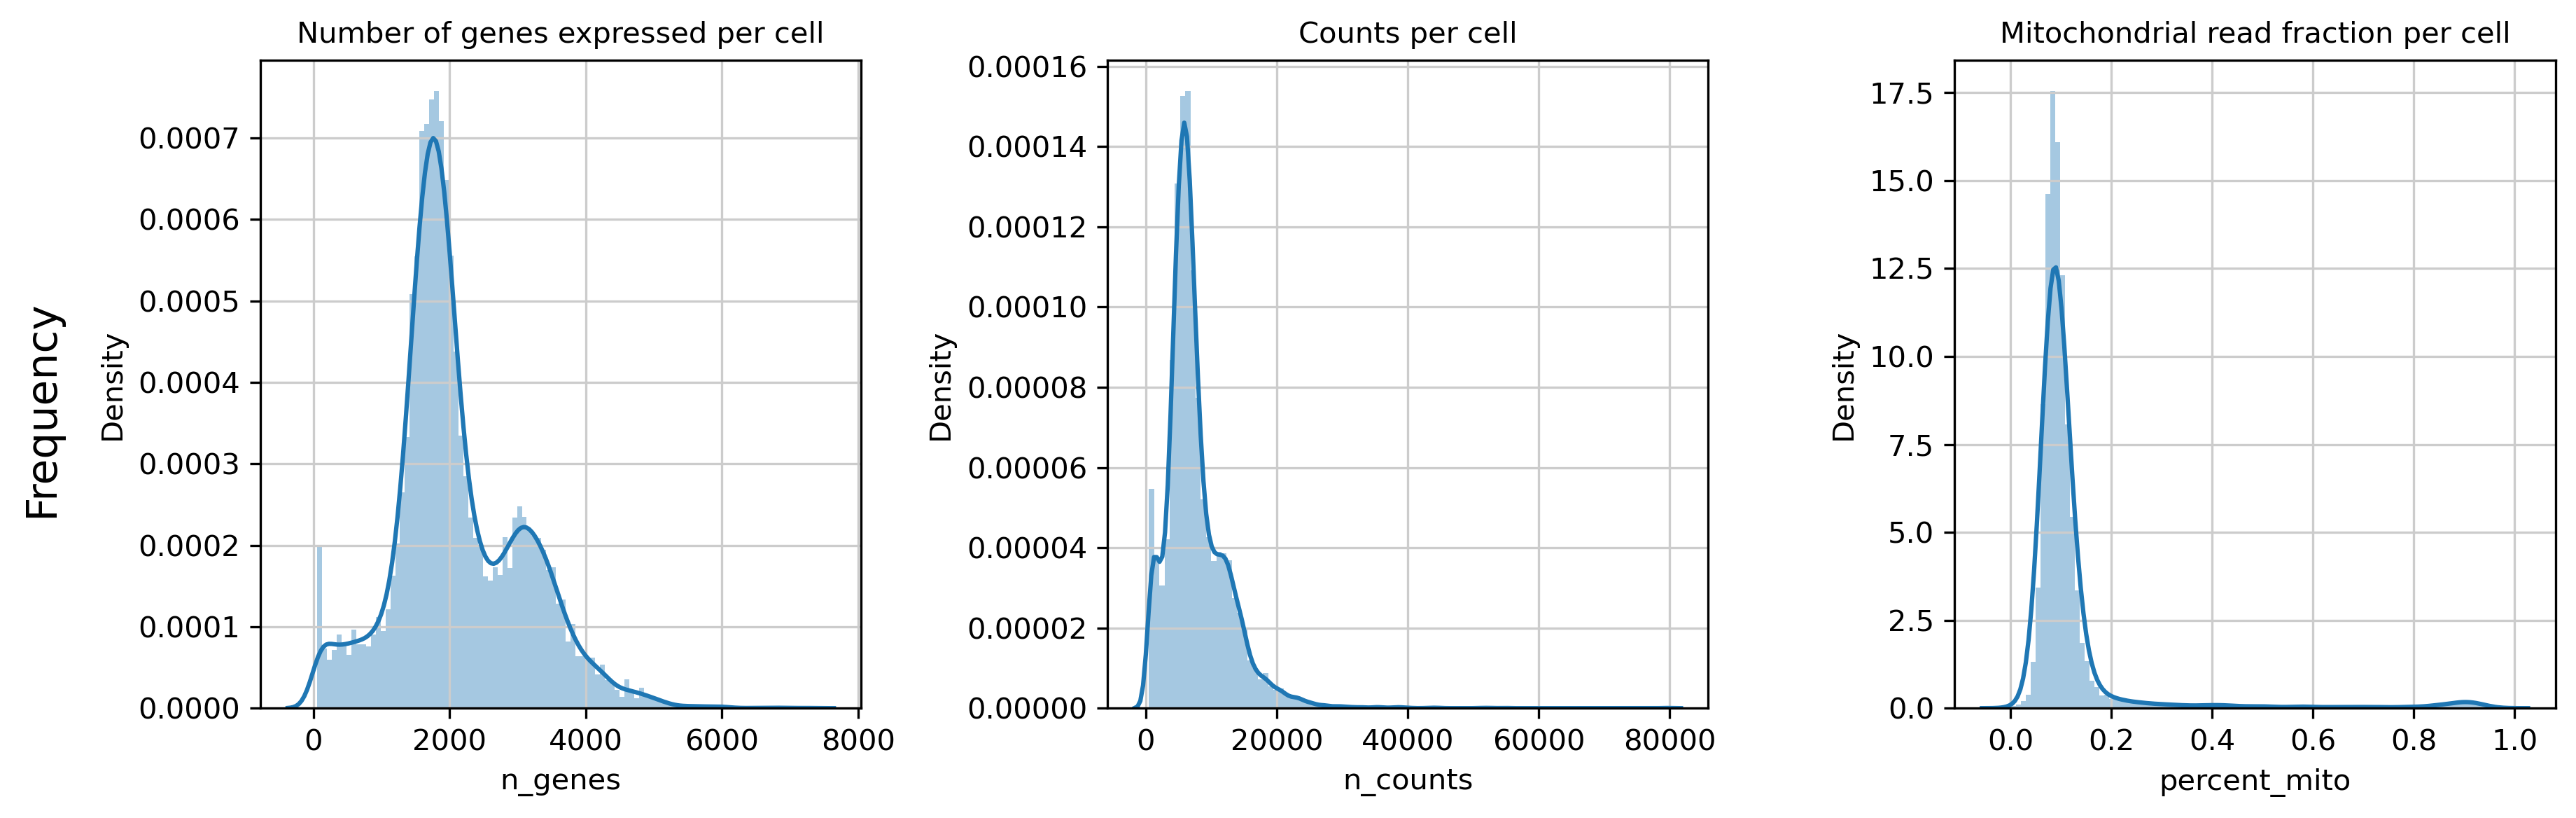

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_prefilter.pdf', dpi=600, bbox_inches='tight')

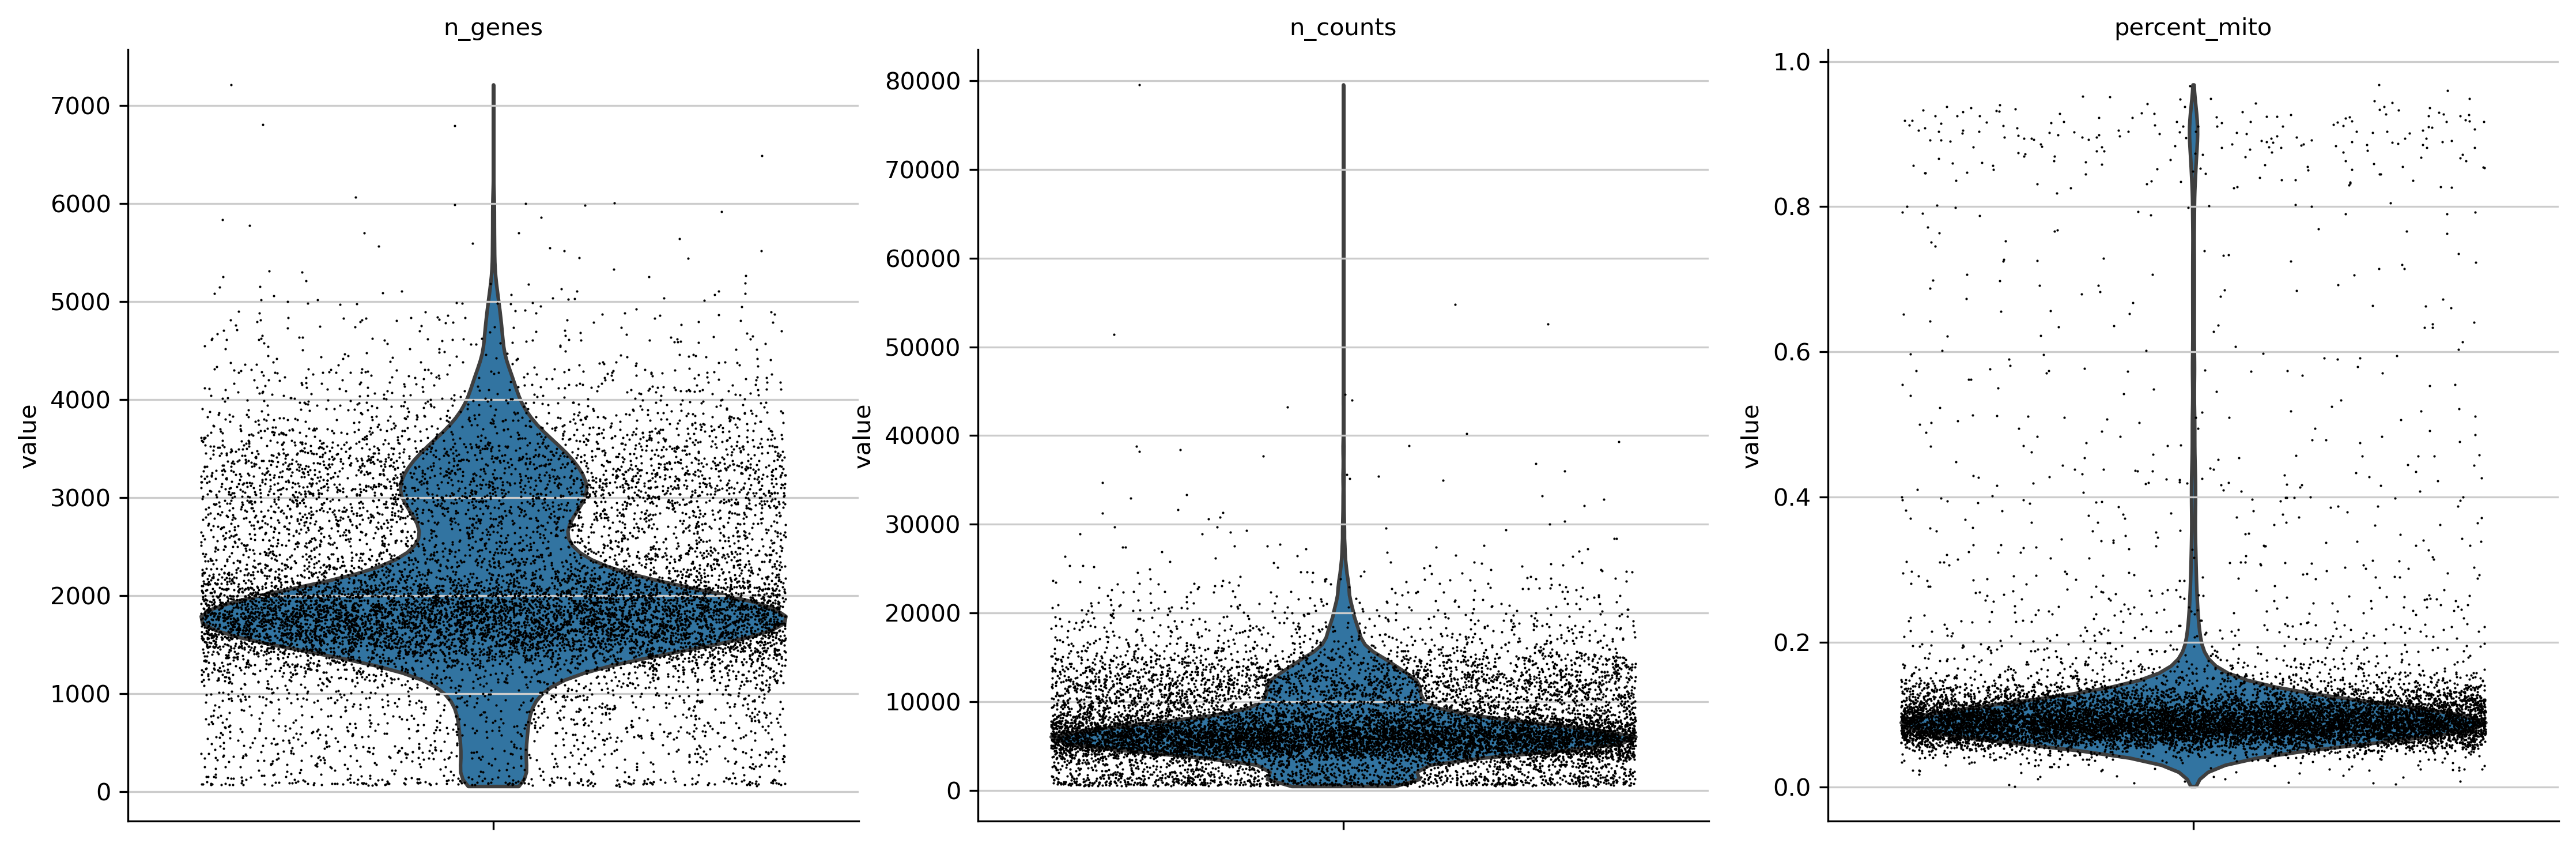

In [21]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

#### Scatter plot, n_genes by n_counts

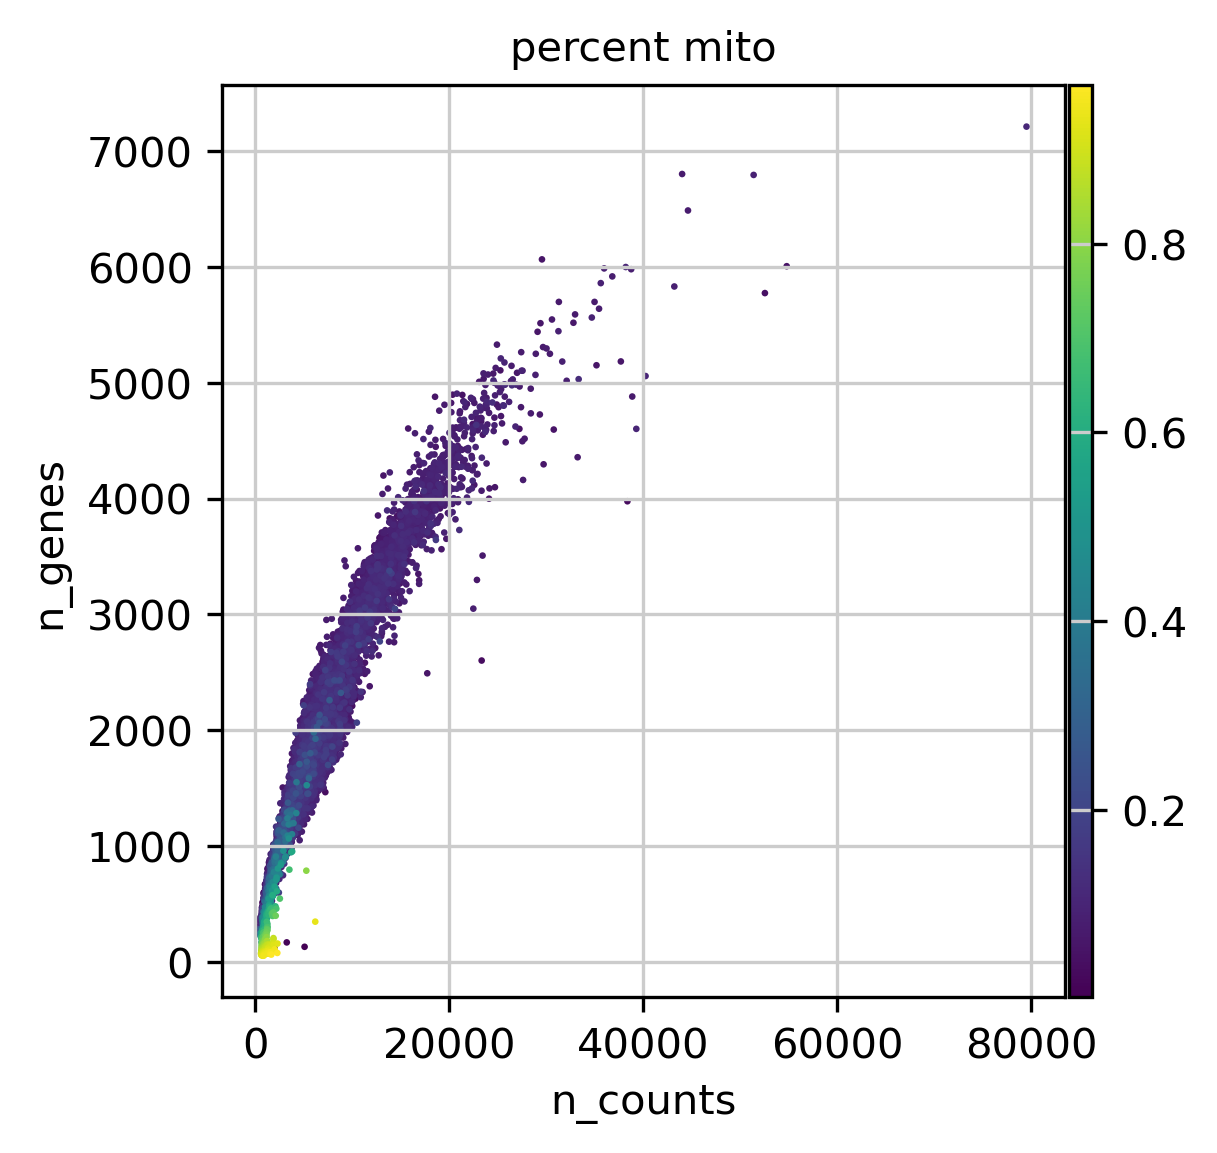

In [22]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

### c. Filtering steps with basic thresholds

In [23]:
#Minimum number of genes for each cell
sc.pp.filter_cells(adata, min_genes=200)

filtered out 232 cells that have less than 200 genes expressed


In [24]:
#Minimum number of genes for each cell
sc.pp.filter_genes(adata, min_cells=3)

filtered out 13246 genes that are detected in less than 3 cells


In [25]:
#Setting max number of genes
adata = adata[adata.obs['n_genes'] < 4000, :]

In [26]:
#Setting quality control threshold
adata = adata[adata.obs['percent_mito'] < 0.15, :]

## 4. Post-filtering plots
**Optional**

#### Three-panel summary plots

/tmp/ipykernel_359/4135359199.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
/tmp/ipykernel_359/4135359199.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
/tmp/ipykernel_35

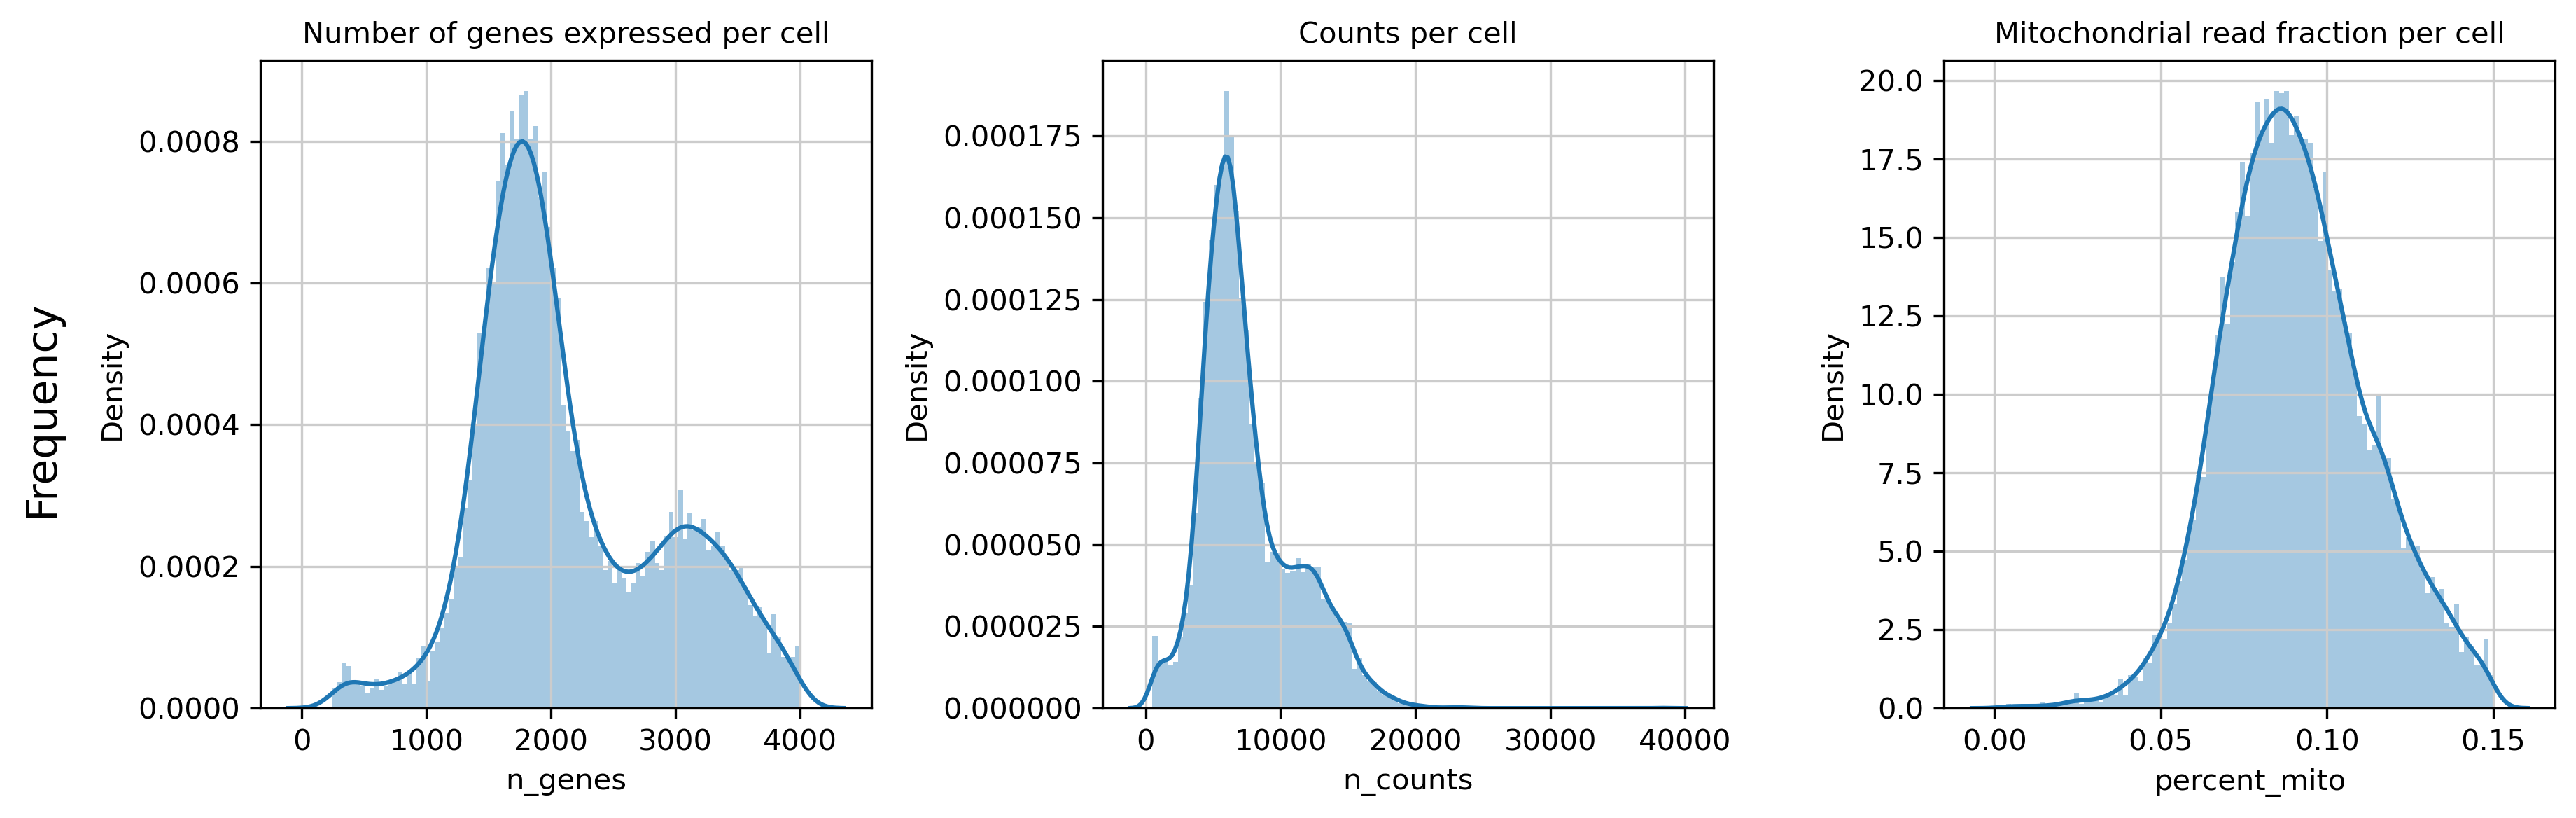

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

adata.obs['n_genes']

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_postfilter.pdf', dpi=600, bbox_inches='tight')

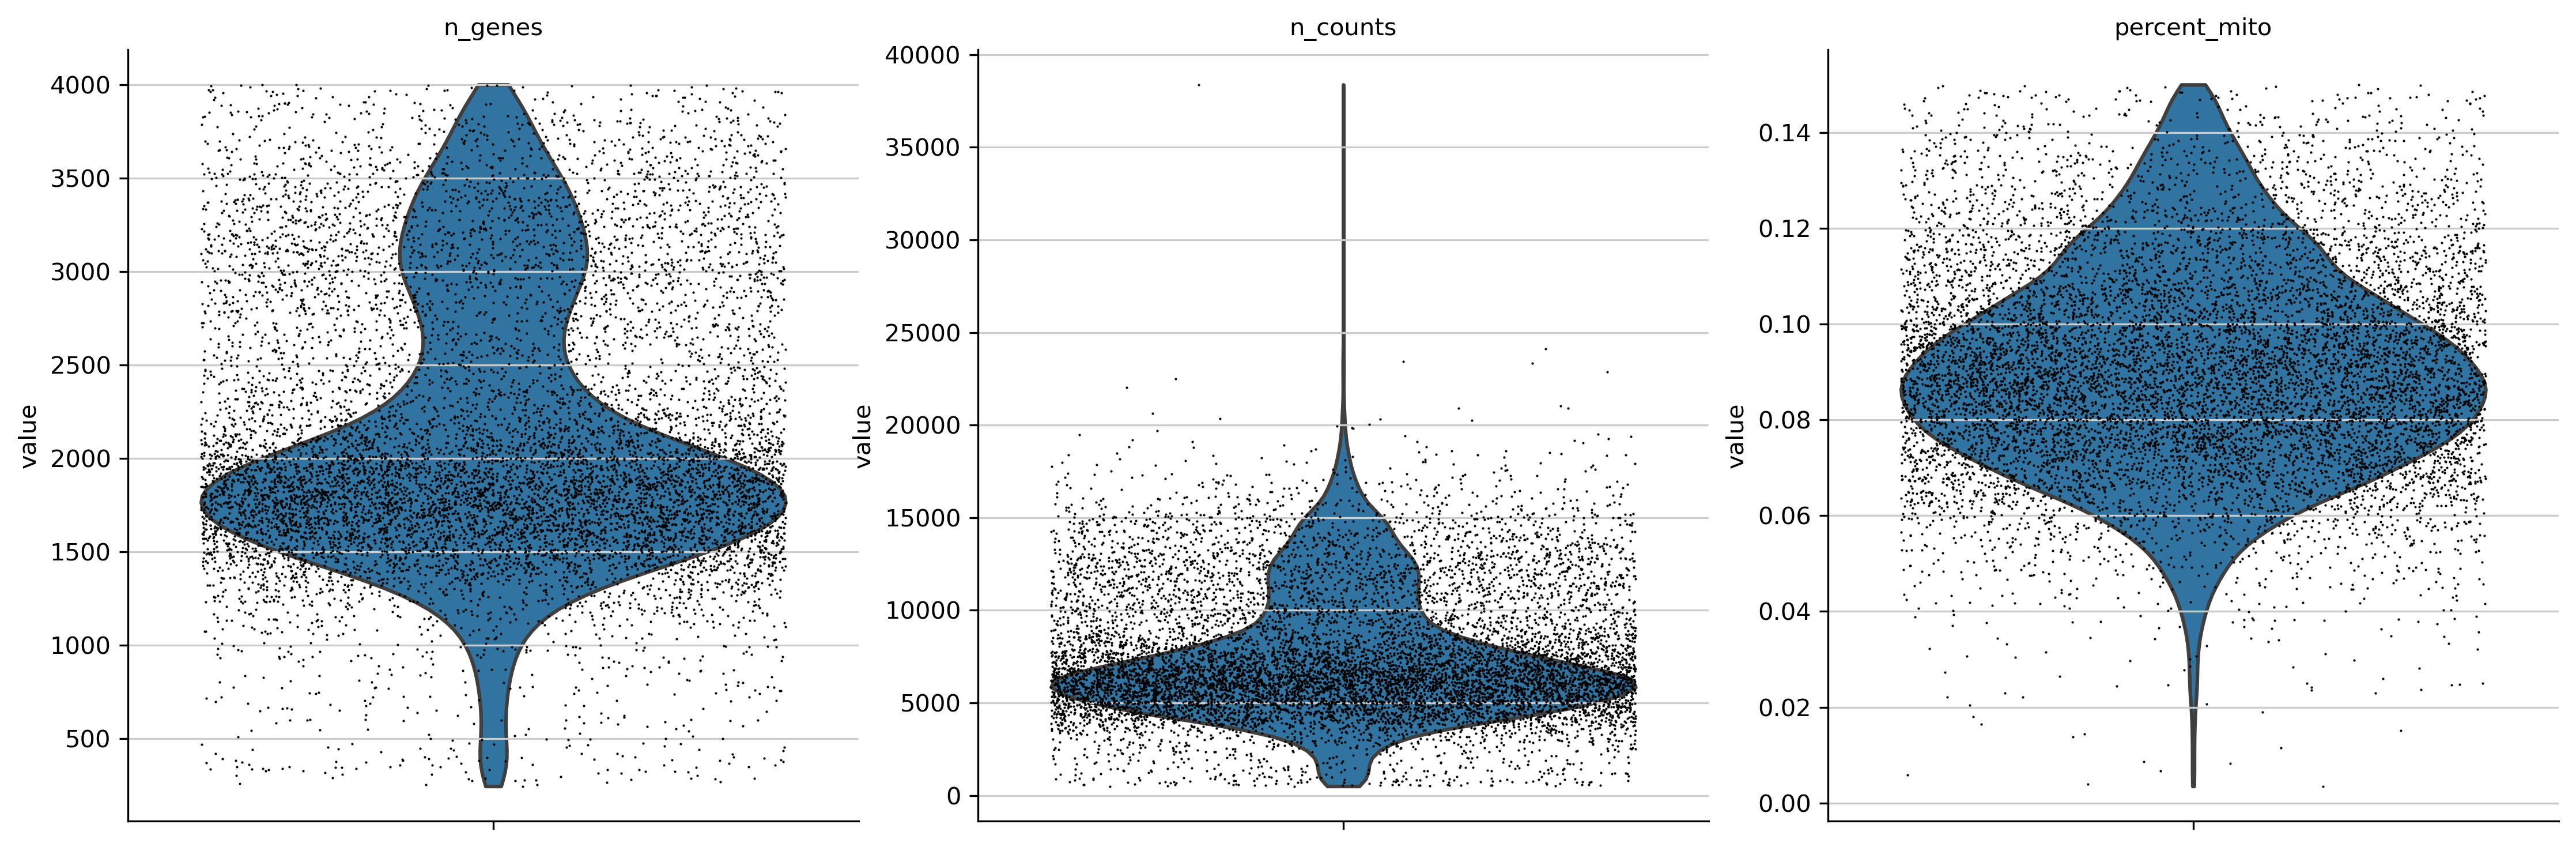

In [28]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

#### Scatter plot, n_genes by n_counts

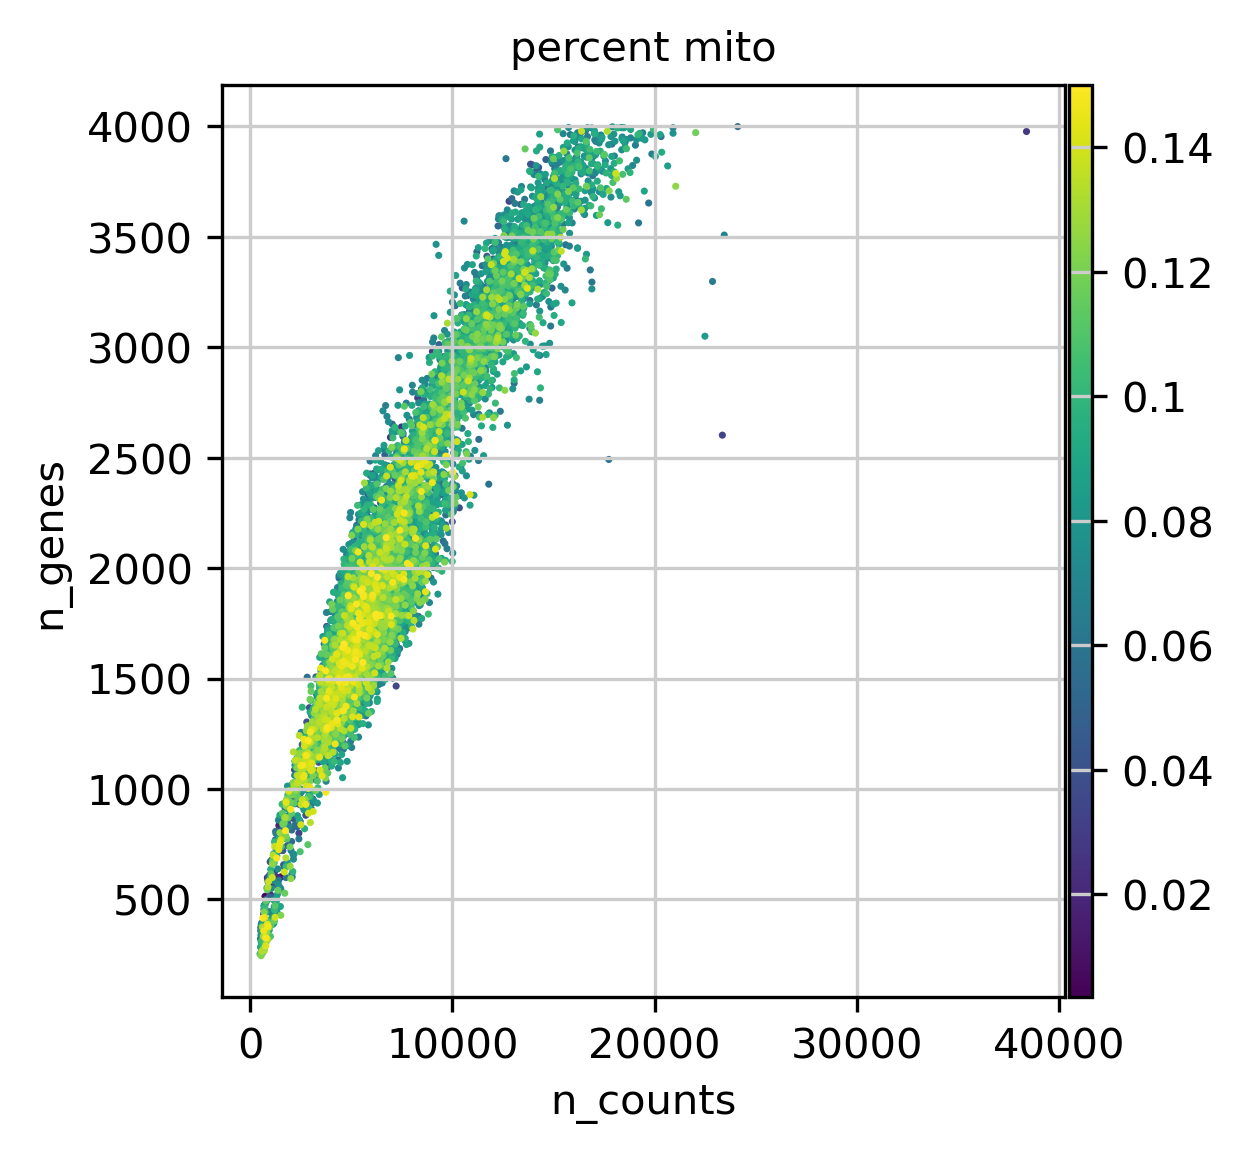

In [29]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

## 5. pySCENIC preparation

### A. Writing the ada file
Update the anndata file, to be used for further processing, clustering, visualization, etc..

In [30]:
#Checking the adata file
adata

View of AnnData object with n_obs × n_vars = 10280 × 20292
    obs: 'nGene', 'nUMI', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [31]:
#Update the anndata file, to be used for further processing, clustering, visualization, etc..
adata.write( f_anndata_path )

### B. Creating a loom file

Output the basic filtered expression matrix to a loom file.  

This can also be used in the command-line pySCENIC steps, for example, or as an input to the Nextflow pipeline.

In [32]:
import loompy as lp
row_attrs = { 
    "Gene": np.array(adata.var_names),             
} 

col_attrs = { 
    "CellID": np.array(adata.obs_names), "nGene": np.array(np.sum(adata.X.transpose()>0, axis=0)).flatten(), "nUMI": np.array(np.sum(adata.X.transpose(),axis=0)).flatten(), 
} 

lp.create("intermediate/PBMC10k_filtered.loom",adata.X.transpose(),row_attrs, col_attrs)

### C. recovering the matrix

#### Inspecting the adata object

In [33]:
#Checking the internal array
type(np.array(adata.X.transpose()))

numpy.ndarray

In [34]:
#Checking contents
adata.X.transpose()

<20292x10280 sparse matrix of type '<class 'numpy.float32'>'
	with 22024659 stored elements in Compressed Sparse Column format>

In [35]:
#Trying to convert to Dataframe
adata.to_df()

Gene,AL627309.1,AL627309.3,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.3,SAMD11,NOC2L,KLHL17,...,MT-ND6,MT-CYB,BX004987.1,AC145212.1,MAFIP,AC011043.1,AL592183.1,AC007325.4,AL354822.1,AC240274.1
CellID,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGCGCCCAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCACAGAGTTGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCACAGGTATGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCACATAGTCAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCACATCCAATG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTCTGTAAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGGTGCGTCGT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGGTTTGAACC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
#Checking gene attribute
np.array(adata.var_names).shape

(20292,)

In [37]:
#Checking Cell ID attribute
np.array(adata.obs_names).shape

(10280,)

In [38]:
#Checking nGene
np.array(np.sum(adata.X.transpose()>0, axis=0)).flatten().shape

(10280,)

Ok, so nGene is just a 1D array that contains the total number of genes whose count was greater than 0 (first it becomes a Boolean matrix, then np.sum takes place) per cell

In [39]:
#Checking nUMI
np.array(np.sum(adata.X.transpose(),axis=0)).flatten()

array([2204., 5884., 5530., ..., 4245., 5601., 6757.], dtype=float32)

Ok, so nUMI is just a 1D array that contains the total number of genes counts per cell

#### Obtaining the dataframe

In [40]:
#Obtaining matrix dataframe
ex_matrix = adata.to_df()

In [41]:
#Checking matrix info
ex_matrix.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 10280 entries, AAACCCAAGCGCCCAT-1 to TTTGTTGTCTTACTGT-1
Columns: 20292 entries, AL627309.1 to AC240274.1
dtypes: float32(20292)
memory usage: 797.1 MB


In [42]:
#Checking for NaN
ex_matrix.isnull().values.any()

False

In [43]:
#Counting NaN
ex_matrix.isnull().sum().sum()

0

In [44]:
#Describe matrix
#ex_matrix.describe()

In [45]:
#Saving the matrix
#ex_matrix.to_csv(ex_matrix_path)

In [46]:
#Saving matrix as a pickle
ex_matrix.to_pickle(ex_matrix_path+'.pkl')

#### Converting the dtype

In [48]:
#Finding the dtypes
display(ex_matrix.dtypes)

Gene
AL627309.1    float32
AL627309.3    float32
AL669831.5    float32
FAM87B        float32
LINC00115     float32
               ...   
AC011043.1    float32
AL592183.1    float32
AC007325.4    float32
AL354822.1    float32
AC240274.1    float32
Length: 20292, dtype: object

In [49]:
#Finding what the column consists of
ex_matrix.dtypes.values[0]

dtype('float32')

In [50]:
#Checking if effectively all column dtypes are "float32"
ex_matrix.dtypes.where(lambda x : x!=np.float32).dropna()

Series([], dtype: object)

In [51]:
ex_matrix.columns.values

array(['AL627309.1', 'AL627309.3', 'AL669831.5', ..., 'AC007325.4',
       'AL354822.1', 'AC240274.1'], dtype=object)

In [52]:
#Changing all dtypes to int64
#col_names = list(ex_matrix.columns.values)
#ex_matrix_int.loc[:,col_names] = ex_matrix.loc[:,col_names].astype(int) #Crashes kernel
#ex_matrix_int = ex_matrix.loc[:,:]

#for c in ex_matrix.columns:
#    ex_matrix_int.loc[:, c] = ex_matrix.loc[:, c].astype(int)

ex_matrix_int = ex_matrix.astype(int)

In [55]:
#Checking the dataframe
ex_matrix_int.shape

(10280, 20292)

In [58]:
#Saving the final int64_matrix as a pickle
ex_matrix_int.to_pickle(ex_matrix_path_final)

## SCENIC steps

### STEP 1: Gene regulatory network inference, and generation of co-expression modules

#### Phase Ia: GRN inference using the GRNBoost2 algorithm

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system. We use the counts matrix (without log transformation or further processing) from the loom file we wrote earlier.
_Output:_ List of adjacencies between a TF and its targets stored in `ADJACENCIES_FNAME`.

In [ ]:
### CLI version
!pyscenic grn {f_loom_path_scenic} {f_tfs} -o adj.csv --num_workers 20

#### Using arboreto GRNboost2 version
**Note: You can start from here if a filtered expression matrix dataframe is available**

In [6]:
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

In [11]:
#Loading the final int64_matrix as a pickle
ex_matrix_int = pd.read_pickle(ex_matrix_path_final)

In [8]:
#Checking matrix
ex_matrix_int.head()

Gene,AL627309.1,AL627309.3,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.3,SAMD11,NOC2L,KLHL17,...,MT-ND6,MT-CYB,BX004987.1,AC145212.1,MAFIP,AC011043.1,AL592183.1,AC007325.4,AL354822.1,AC240274.1
CellID,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGCGCCCAT-1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
AAACCCACAGAGTTGG-1,0,0,0,0,0,0,0,0,0,0,...,0,44,0,0,0,0,0,0,0,0
AAACCCACAGGTATGG-1,0,0,0,0,0,0,0,0,1,0,...,1,31,0,0,0,0,0,0,0,0
AAACCCACATAGTCAC-1,0,0,0,0,0,0,0,0,1,0,...,1,37,0,0,0,0,0,0,0,0
AAACCCACATCCAATG-1,0,0,0,0,0,0,0,0,0,0,...,1,24,0,0,0,0,0,0,1,0


In [9]:
#Matrix shape
ex_matrix_int.shape

(10280, 20292)

In [10]:
# transcription factors list
f_tfs = "/home/jovyan/work/dask_k8s/PBMC_project/work_dir/input/hs_hgnc_tfs.txt" # human
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_dmel.txt" # drosophila
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_mm.txt"   # mouse
# tf_names = load_tf_names( f_tfs )

In [11]:
#Load tf names
tf_names = load_tf_names(f_tfs)

In [12]:
#Getting TF list length
len(tf_names)

1839

##### Timestamp

In [13]:
from datetime import datetime
currentDateAndTime = datetime.now()
currentDateAndTime = currentDateAndTime.strftime("%Y_%m_%d_%H-%M-%S")
print(currentDateAndTime)

2023_03_06_16-29-54


In [14]:
#Start date 
!date -u +"%c"

Mon 06 Mar 2023 04:29:55 PM UTC


In [15]:
#Start date Unix
!date +"%s"

1678120195


##### GRNboost2

In [16]:
#Checking the client access is present
c

<Client: 'tcp://10.42.3.18:8786' processes=4 threads=28, memory=21.23 GiB>

In [17]:
### GRNboost2 version
if __name__ == '__main__':
    from dask.distributed import performance_report
    with performance_report(filename="stress_testing/dask-report_%s.html"%(currentDateAndTime)):
       adjacencies = grnboost2(ex_matrix_int, tf_names=tf_names, verbose=True, client_or_address=c)

preparing dask client
parsing input
creating dask graph
4 partitions
computing dask graph
not shutting down client, client was created externally
finished


In [18]:
#end date 
!date -u +"%c"

Mon 06 Mar 2023 06:26:06 PM UTC


#### Checking adjacencies

In [21]:
#Checking the adjacencies matrix
adjacencies.head()

,TF,target,importance
532,RPS4X,RPS23,222.728552
532,RPS4X,RPS3A,222.040092
532,RPS4X,RPL13,219.291544
532,RPS4X,RPL32,206.731376
532,RPS4X,RPL35A,202.391352


In [22]:
#Checking adjacencies shape
adjacencies.shape

(4975960, 3)

In [20]:
#Saving adjacencies to pickle
adjacencies.to_pickle("intermediate/adjacencies.pkl")

In [6]:
#Checking adjacencies file size
adjacencies.info(memory_usage="deep")

NameError: name 'adjacencies' is not defined

read in the adjacencies matrix:

### STEP 2-3: Regulon prediction aka cisTarget from CLI

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

_Output:_ List of adjacencies between a TF and its targets stored in `MOTIFS_FNAME`.

In [6]:
#Retrieve libraries
import glob

from dask.diagnostics import ProgressBar

from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons

#### CLI version

locations for ranking databases, and motif annotations:

In [42]:
import glob
# ranking databases
f_db_glob = "/ddn1/vol1/staging/leuven/res_00001/databases/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "/ddn1/vol1/staging/leuven/res_00001/databases/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

Here, we use the `--mask_dropouts` option, which affects how the correlation between TF and target genes is calculated during module creation. It is important to note that prior to pySCENIC v0.9.18, the default behavior was to mask dropouts, while in v0.9.18 and later, the correlation is performed using the entire set of cells (including those with zero expression). When using the `modules_from_adjacencies` function directly in python instead of via the command line, the `rho_mask_dropouts` option can be used to control this.

In [ ]:
!pyscenic ctx adj.tsv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 20

#### Jupyter version

##### 1. Recovering previous files

In [44]:
#Loading the final int64_matrix as a pickle
ex_matrix_int = pd.read_pickle(ex_matrix_path_final)

In [45]:
#What is the column name data type
type(ex_matrix_int.head().columns[0])

str

In [46]:
ex_matrix_int.shape

(10280, 20292)

In [48]:
#Checking unqiue columns
ex_matrix_int.columns.nunique()

20292

In [8]:
#Re-loading the adjacencies dataframe
#adjacencies = pd.read_csv("adj.tsv", index_col=False, sep='\t')
adj = pd.read_pickle("intermediate/adjacencies.pkl").reset_index(drop=True)

In [9]:
adj.head()

,TF,target,importance
0,RPS4X,RPS23,222.728552
1,RPS4X,RPS3A,222.040092
2,RPS4X,RPL13,219.291544
3,RPS4X,RPL32,206.731376
4,RPS4X,RPL35A,202.391352


In [26]:
#Check if targets are unique
a = len(adj.loc[:,'target'])
b = adj.loc[:,'target'].nunique()
print("There are %d targets and %d unique targets"%(a,b))

There are 4975960 targets and 20286 unique targets


In [30]:
#Investigating PRKAB1
adj.loc[:,:].query("target == 'PRKAB1'")

,TF,target,importance
128522,ZNF507,PRKAB1,4.300576e+00
180434,MGA,PRKAB1,3.121532e+00
183764,ZNF140,PRKAB1,3.064325e+00
195059,HNRNPC,PRKAB1,2.890363e+00
270695,FOSB,PRKAB1,2.068066e+00
...,...,...,...
4322410,PIK3C3,PRKAB1,2.321305e-02
4836148,LMO2,PRKAB1,2.341723e-05
4868334,GPANK1,PRKAB1,6.234382e-06
4895379,ATF4,PRKAB1,1.138019e-06


In [12]:
#Finding datatypes
adj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4975960 entries, 0 to 4975959
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   TF          object 
 1   target      object 
 2   importance  float64
dtypes: float64(1), object(2)
memory usage: 113.9+ MB


In [13]:
#What is the object data type?
type(adj.loc[0,"TF"])

str

##### Adjacency issue: **This is a problem, adjacencies should be python strings, not numpy strings**

In [76]:
#Checking strategy 1
type(adj['TF'].apply(str)[0])

str

Strategy 1 worked.

In [77]:
#Converting numpy strings to strings
adj.loc[:,"TF"] = adj.loc[:,"TF"].apply(str)
adj.loc[:,"target"] = adj.loc[:,"target"].apply(str)

In [78]:
#Checking that it worked
print(type(adj.loc[0,"TF"]), type(adj.loc[0,"target"]))

<class 'str'> <class 'str'>


Doing the same for the matrix

In [16]:
#Check matrix
ex_matrix_int.head()

Gene,AL627309.1,AL627309.3,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.3,SAMD11,NOC2L,KLHL17,...,MT-ND6,MT-CYB,BX004987.1,AC145212.1,MAFIP,AC011043.1,AL592183.1,AC007325.4,AL354822.1,AC240274.1
CellID,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGCGCCCAT-1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
AAACCCACAGAGTTGG-1,0,0,0,0,0,0,0,0,0,0,...,0,44,0,0,0,0,0,0,0,0
AAACCCACAGGTATGG-1,0,0,0,0,0,0,0,0,1,0,...,1,31,0,0,0,0,0,0,0,0
AAACCCACATAGTCAC-1,0,0,0,0,0,0,0,0,1,0,...,1,37,0,0,0,0,0,0,0,0
AAACCCACATCCAATG-1,0,0,0,0,0,0,0,0,0,0,...,1,24,0,0,0,0,0,0,1,0


In [22]:
#Trying out one strategy
type(ex_matrix_int.columns.astype(str)[0])

str

In [23]:
#Changing dataframe column name data type
ex_matrix_int.columns = ex_matrix_int.columns.astype(str)

In [24]:
#Checking it worked
type(ex_matrix_int.columns[0])

str

**Saving the adjacency and matrix dataframes again**

In [79]:
#Saving corrected adjacencies to file
adj.to_pickle("intermediate/adjacencies.pkl")

In [25]:
ex_matrix_int.to_pickle(ex_matrix_path_final)

##### 2. Obtaining the modules

In [28]:
#Obtaining module list
modules = list(modules_from_adjacencies(adj, ex_matrix_int))


2023-03-07 15:03:16,868 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-03-07 15:03:19,204 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2023-03-07 15:09:17,141 - pyscenic.utils - INFO - Creating modules.


In [29]:
#Checking object type
type(modules)

list

In [30]:
#Checking a module
modules[0:1]

[Regulon(name='Regulon for ABCF2', gene2weight=frozendict.frozendict({'BLOC1S4': 3.8883134001773674, 'AC025569.1': 2.7975713201277657, 'AL031727.2': 2.2741437119927017, 'TJP3': 2.0735453749951667, 'ARMC4': 1.660282002939232, 'SURF2': 1.4162516048596163, 'APOLD1': 1.3683768528224427, 'SVIL': 1.3655052624100976, 'MYEF2': 1.352690307770141, 'CNIH4': 1.3526575685304323, 'SLC2A14': 1.2746309419771755, 'EPHB1': 1.1623605613933834, 'ATMIN': 1.124661879043885, 'AC051619.4': 1.117035623835917, 'SIM2': 1.0636031731293294, 'CD1E': 1.0172416268479494, 'AL121829.2': 0.9679344418701228, 'C12orf29': 0.9461028086359602, 'AC138932.2': 0.8705943986258149, 'DNPH1': 0.7968775456072786, 'TBX6': 0.7722706577904872, 'OSTM1': 0.7213278455695716, 'MRPL22': 0.6782911721394753, 'FGFR1OP': 0.6689083270145794, 'RASSF6': 0.6631870097789466, 'TRBV2': 0.6513550273629796, 'LARP6': 0.6506068228519692, 'C7orf65': 0.6149115600805583, 'DST': 0.5853195198818688, 'RP1L1': 0.5626292416510819, 'AC006111.3': 0.5610335990768431

In [31]:
#Saving the module to a file
def write_modules(md, path):
    # store list in binary file so 'wb' mode
    with open(path, 'wb') as fh:
        pk.dump(md, fh)
        print('Done writing list into a binary file')

write_modules(modules, 'intermediate/modules.pk')

Done writing list into a binary file


#### 2. Retrieving the feather database

In [7]:
#Retrieving the databases path
DATABASE_FOLDER = os.environ['DATABASES_PATH']
DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "PBMC/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather")

In [8]:
DATABASES_GLOB

'/mnt/databases/PBMC/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'

In [9]:
#Loading ranking databases
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings")]

In [10]:
dbs[0]

FeatherRankingDatabase(name="hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings")

#### 3. Checking the database

In [11]:
#Reproducing module load
dbs[0].load(modules[1018])

NameError: name 'modules' is not defined

#### 3. Running prune2_df

In [12]:
#Retrieving modules
def read_modules(path):
    # accessing the same file
    with open(path, 'rb') as fh:
        n_list = pk.load(fh)
        return n_list

modules = read_modules('intermediate/modules.pk')

In [13]:
#Checking that the module is composed of strings
modules[0].name

'Regulon for ABCF2'

In [50]:
for i, module in enumerate(modules[1029:1037]):
    if module.gene2weight.get('ABCB4', ""): #and module.gene2weight.get('A1BG-AS1', ""):
    #if module.name == "Regulon for ZNF154":
        print(i)

7


In [38]:
modules[1036].gene2weight.get('lol', "")

''

In [57]:
#Start date 
!date -u +"%c"

Wed 08 Mar 2023 02:38:54 AM UTC


In [58]:
# Calculate a list of enriched motifs and the corresponding target genes for all modules.
#%pdb on

with ProgressBar():
    def func():
        #set_trace()
        return prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME, client_or_address=c)
    df = func()

In [59]:
df.head()

Enrichment                                  \
                                      AUC       NES MotifSimilarityQvalue   
TF     MotifID                                                              
BCLAF1 hdpi__ELF2                0.062986  3.327352              0.000732   
CHD2   transfac_pro__M04817      0.064166  3.129690              0.000018   
E2F1   transfac_pro__M04746      0.043480  3.381166              0.000000   
       transfac_public__M00024   0.055546  5.452161              0.000000   
EGR1   transfac_pro__M04918      0.059312  3.501842              0.000000   

                                                    \
                               OrthologousIdentity   
TF     MotifID                                       
BCLAF1 hdpi__ELF2                              1.0   
CHD2   transfac_pro__M04817                    1.0   
E2F1   transfac_pro__M04746                    1.0   
       transfac_public__M00024                 1.0   
EGR1   transfac_pro__M04918                    1.0   

                                                                                   \
                                                                       Annotation   
TF     MotifID                                                                      
BCLAF1 hdpi__ELF2               gene is annotated for similar motif dbcorrdb__...   
CHD2   transfac_pro__M04817     motif similar to dbcorrdb__CHD2__ENCSR000ECP_1...   
E2F1   transfac_pro__M04746                            gene is directly annotated   
       transfac_public__M00024                         gene is directly annotated   
EGR1   transfac_pro__M04918                            gene is directly annotated   

                                                                                   \
                                                                          Context   
TF     MotifID                                                                      
BCLAF1 hdpi__ELF2               (weight>75.0%, hg38_10kbp_up_10kbp_down_full_t...   
CHD2   transfac_pro__M04817     (weight>75.0%, hg38_10kbp_up_10kbp_down_full_t...   
E2F1   transfac_pro__M04746     (weight>75.0%, hg38_10kbp_up_10kbp_down_full_t...   
       transfac_public__M00024  (weight>75.0%, hg38_10kbp_up_10kbp_down_full_t...   
EGR1   transfac_pro__M04918     (weight>75.0%, hg38_10kbp_up_10kbp_down_full_t...   

                                                                                   \
                                                                      TargetGenes   
TF     MotifID                                                                      
BCLAF1 hdpi__ELF2               [(UBE3A, 0.843685743076456), (KTN1, 1.18378860...   
CHD2   transfac_pro__M04817     [(NUTM2B-AS1, 0.4946768321963085), (SPTBN1, 0....   
E2F1   transfac_pro__M04746     [(FBXW4, 2.8164604985438175), (HNRNPF, 1.69518...   
       transfac_public__M00024  [(ESYT2, 1.0599901719477225), (HES4, 1.3128037...   
EGR1   transfac_pro__M04918     [(LATS2, 0.567906633872596), (ING2, 0.44913938...   

                                          
                               RankAtMax  
TF     MotifID                            
BCLAF1 hdpi__ELF2                   1438  
CHD2   transfac_pro__M04817         1161  
E2F1   transfac_pro__M04746         1310  
       transfac_public__M00024      1248  
EGR1   transfac_pro__M04918         1447

In [62]:
df.shape

(119, 8)

In [61]:
#Saving motifs to file
df.to_csv("intermediate/motifs.csv")

In [63]:
#Obtaining regulons
regulons = df2regulons(df)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [67]:
#Saving regulons
with open("intermediate/regulons.pkl", "wb") as f:
    pk.dump(regulons, f)

### STEP 4: Cellular enrichment (aka AUCell) from CLI

It is important to check that most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC.
The following histogram gives an idea of the distribution and allows selection of an appropriate threshold.
In this plot, a few thresholds are highlighted, with the number of genes selected shown in red text and the corresponding percentile in parentheses).
See [the relevant section in the R tutorial](https://bioconductor.org/packages/devel/bioc/vignettes/AUCell/inst/doc/AUCell.html#build-gene-expression-rankings-for-each-cell) for more information.

By using the default setting for `--auc_threshold` of `0.05`, we see that **1192** genes are selected for the rankings based on the plot below.

In [114]:
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
percentiles = nGenesDetectedPerCell.quantile([.01, .05, .10, .50, 1])
print(percentiles)

0.01     473.58
0.05    1192.00
0.10    1390.90
0.50    1939.00
1.00    3998.00
dtype: float64


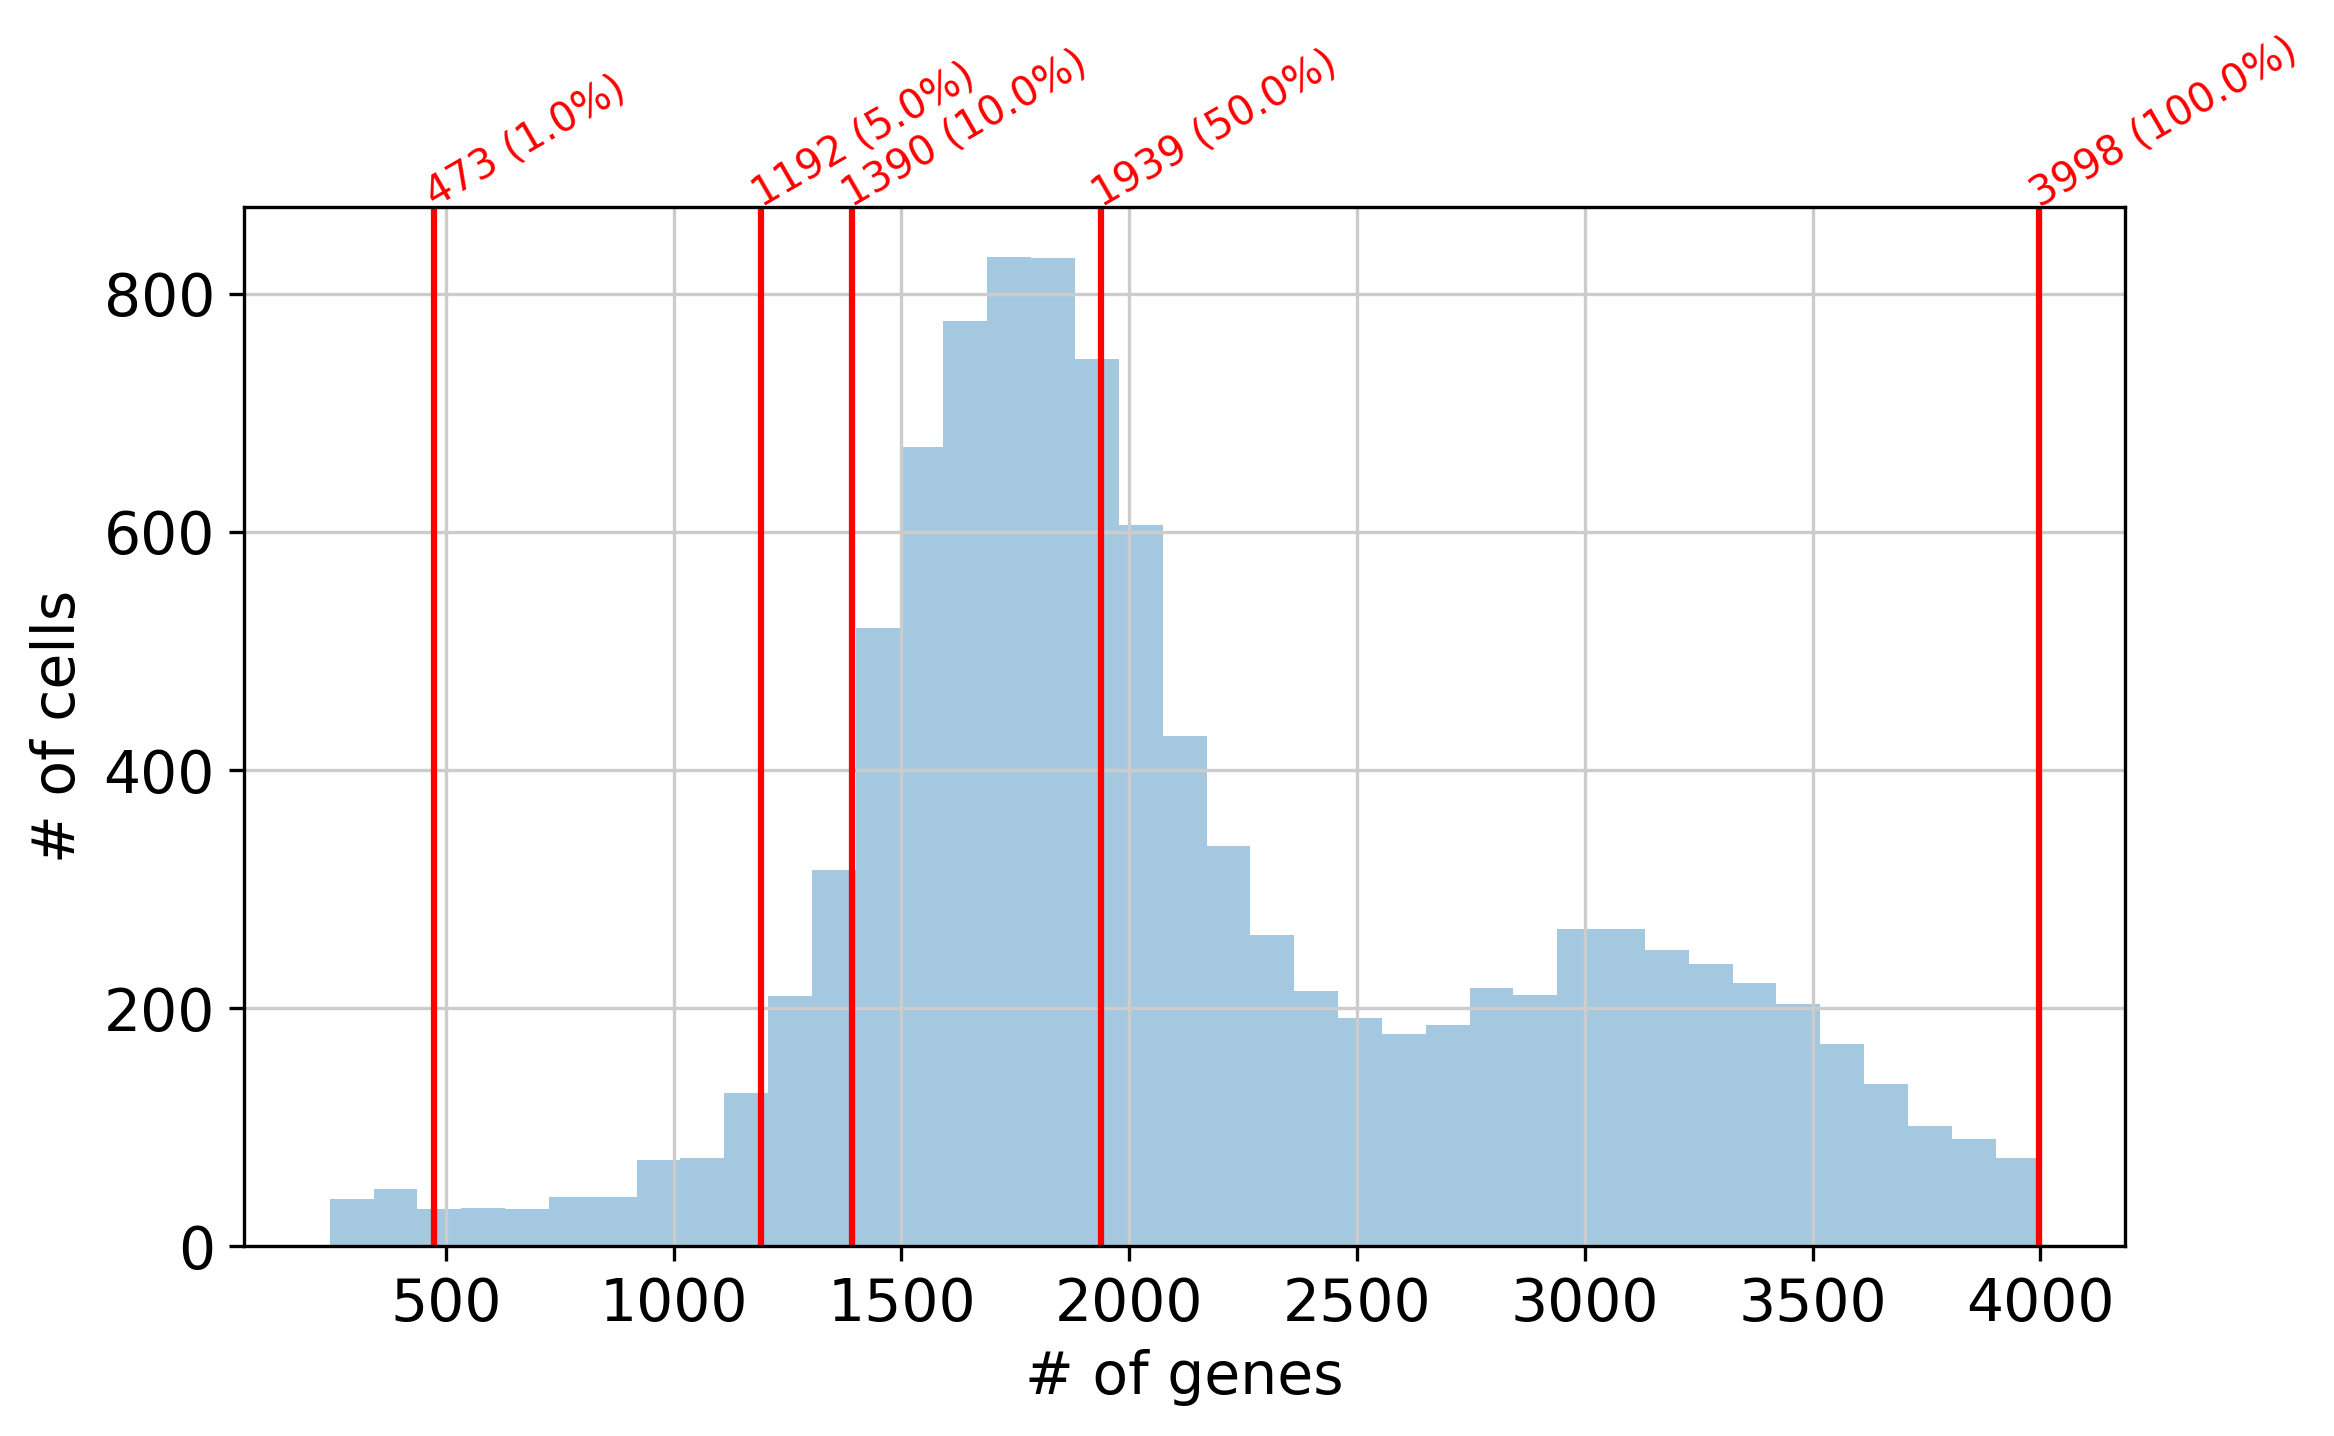

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [45]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 20

/usr/local/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/usr/local/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
2019-07-23 10:50:01,763 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.
2019-07-23 10:50:04,612 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
2019-07-23 10:50:32,534 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.
2019-07-23 10:50:52,367 - pyscenic.cli.pyscenic - INFO - Writing results to file.
100%|#########################################| 389/389 [31:18<00:00,  2.97s/it]


### Visualization of SCENIC's AUC matrix

First, load the relevant data from the loom we just created

In [48]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [53]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_tsne.txt", sep='\t')

## Integrate the output

Here, we combine the results from SCENIC and the Scanpy analysis into a SCope-compatible loom file

In [57]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###

Fix regulon objects to display properly in SCope:

In [58]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

Concatenate embeddings (tSNE, UMAP, etc.)

In [60]:
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']

Metadata:

In [64]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": f"Scanpy t-SNE (highly variable genes)"
    },
    {
        "id": 1,
        "name": f"Scanpy UMAP  (highly variable genes)"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy louvain default resolution",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    {
        "name": "Louvain_clusters_Scanpy",
        "values": list(set( adata.obs['louvain'].astype(np.str) ))
    },
    #{
    #    "name": "Genotype",
    #    "values": list(set(adata.obs['Genotype'].values))
    #},
    #{
    #    "name": "Timepoint",
    #    "values": list(set(adata.obs['Timepoint'].values))
    #},
    #{
    #    "name": "Sample",
    #    "values": list(set(adata.obs['Sample'].values))
    #}
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i + 1}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['louvain'].values.astype(np.int64)

Assemble loom file row and column attributes

In [65]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [67]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['n_counts'].values),
    "nGene": np.array(adata.obs['n_genes'].values),
    "Louvain_clusters_Scanpy": np.array( adata.obs['louvain'].values ),
    #"Genotype": np.array(adata.obs['Genotype'].values),
    #"Timepoint": np.array(adata.obs['Timepoint'].values),
    #"Sample": np.array(adata.obs['Sample'].values),
    "Percent_mito": np.array(adata.obs['percent_mito'].values),
    "Embedding": dfToNamedMatrix(tsneDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['louvain'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "MetaData": json.dumps(metaJson),
    "Genome": 'hg38',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

Create a new loom file, copying the expression matrix from the open loom connection:

In [68]:
lp.create(
    filename = f_final_loom ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file

This loom file can now be imported into [SCope](http://scope.aertslab.org/).